# The Simulator Class

The most convenient way to use ``hera_sim`` is to use the ``Simulator`` class, which builds in all the primary functionality of the ``hera_sim`` package in an easy-to-use interface, and adds the ability to consistently write all produced effects into a ``pyuvdata.UVData`` object (and to file).


This notebook provides a brief tutorial on basic use of the ``Simulator`` class, followed by a longer, more in-depth tutorial that shows some advanced features of the class.

## Setup

In [1]:
import tempfile
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from astropy import units

import hera_sim
from hera_sim import Simulator, DATA_PATH, utils
from uvtools.plot import labeled_waterfall

We'll inspect the visibilities as we go along by plotting the amplitudes and phases on different axes in the same figure. Here's the function we'll be using:

In [2]:
def waterfall(sim, antpairpol=(0, 1, "xx"), figsize=(6, 3.5), dpi=200, title=None):
    """Convenient plotting function to show amp/phase."""
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, dpi=dpi)
    fig, ax1 = labeled_waterfall(
        sim.data, antpairpol=antpairpol, mode="log", ax=ax1, set_title=title
    )
    ax1.set_xlabel(None)
    ax1.set_xticklabels(["" for tick in ax1.get_xticks()])
    fig, ax2 = labeled_waterfall(
        sim.data, antpairpol=antpairpol, mode="phs", ax=ax2, set_title=False
    )
    return fig

## Introduction

The ``Simulator`` class provides an easy-to-use interface for all of the features provided by ``hera_sim``, though it is not to be confused with the ``VisibilitySimulator`` class, which is intended to be a universal interface for high-accuracy visibility simulators commonly used within the community. The ``Simulator`` class features:

* A universal ``add`` method for simulating any effect included in the ``hera_sim`` API.
    * More advanced users can create their own custom effects that the ``Simulator`` can use, as long as these custom effects abide by a certain syntax.
* A ``get`` method for retrieving any previously simulated effect.
    * Simulated effects are not cached, but rather the parameters characterizing the effect are recorded and the desired effect is re-simulated.
* Four modes of specifying how to configure the random state when simulating effects:
    * "redundant" ensures that the random state is set the same for each baseline within a redundant group;
    * "once" uses the same random state when simulating data for every baseline in the array;
    * "initial" only sets the random state initially, prior to simulating data for the array;
    * Similar to "once", the user can provide an integer to seed the random state, which is then used to set the random state for every baseline in the array.
* Convenient methods for writing the data to disk.
    * The ``write`` method writes the entire ``UVData`` object's contents to disk in the desired format.
    * The ``chunk_sim_and_save`` method allows for writing the data to disk in many files with a set number of integrations per file.

In order to enable a simple, single interface for simulating an effect, ``hera_sim`` employs a certain heirarchy to how it thinks about simulated effects. Every simulation effect provided in ``hera_sim`` derives from a single abstract base class, the ``SimulationComponent``. A "component" is a general term for a category of simulated effect, while a "model" is an implementation of a particular effect. Components track all of the models that are particular implementations of the components, and this enables ``hera_sim`` to track every model that is created, so long as it is a subclass of a simulation component. To see a nicely formatted list of all of the components and their models, you can print the output of the ``components.list_all_components`` function, as demonstrated below.

In [3]:
print(hera_sim.components.list_all_components())

array:
  lineararray
  hexarray
eor:
  noiselikeeor | noiselike_eor
foreground:
  diffuseforeground | diffuse_foreground
  pointsourceforeground | pntsrc_foreground
noise:
  thermalnoise | thermal_noise
rfi:
  stations | rfi_stations
  impulse | rfi_impulse
  scatter | rfi_scatter
  dtv | rfi_dtv
gain:
  bandpass | gains | bandpass_gain
  reflections | reflection_gains | sigchain_reflections
  reflectionspectrum | reflection_spectrum
crosstalk:
  crosscouplingcrosstalk | cross_coupling_xtalk
  crosscouplingspectrum | cross_coupling_spectrum | xtalk_spectrum
  mutualcoupling | mutual_coupling | first_order_coupling
  overaircrosscoupling
  whitenoisecrosstalk | whitenoise_xtalk | white_noise_xtalk



The format for the output is structured as follows:  
```
component_1:  
  model_1_name | model_1_alias_1 | ... | model_1_alias_N
  ...
  model_N_name | model_N_alias_1 | ...
component_2:
  ...
```  
So long as there are not name conflicts, ``hera_sim`` is able to uniquely identify which model corresponds to which name/alias, and so there is some flexibility in telling the ``Simulator`` how to find and simulate an effect for a particular model.

## Basic Use

To get us started, let's make a ``Simulator`` object with 100 frequency channels spanning from 100 to 200 MHz, a half-hour of observing time using an integration time of 10.7 seconds, and a 7-element hexagonal array.

In [4]:
# Define the array layout.
array_layout = hera_sim.antpos.hex_array(2, split_core=False, outriggers=0)

# Define the timing parameters.
start_time = 2458115.9  # JD
integration_time = 10.7  # seconds
Ntimes = int(30 * units.min.to("s") / integration_time)

# Define the frequency parameters.
Nfreqs = 100
bandwidth = 1e8  # Hz
start_freq = 1e8  # Hz

sim_params = dict(
    Nfreqs=Nfreqs,
    start_freq=start_freq,
    bandwidth=bandwidth,
    Ntimes=Ntimes,
    start_time=start_time,
    integration_time=integration_time,
    array_layout=array_layout,
)

# Create an instance of the Simulator class.
sim = Simulator(**sim_params)

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


### Overview

The ``Simulator`` class adds some attributes for conveniently accessing metadata:

In [5]:
# Observed frequencies in GHz
sim.freqs[::10]

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])

In [6]:
# Observed Local Sidereal Times (LSTs) in radians
sim.lsts[::10]

array([4.58108965, 4.58889222, 4.59669478, 4.60449734, 4.61229991,
       4.62010247, 4.62790504, 4.6357076 , 4.64351016, 4.65131273,
       4.65911529, 4.66691785, 4.67472042, 4.68252298, 4.69032555,
       4.69812811, 4.70593067])

In [7]:
# Array layout in local East-North-Up (ENU) coordinates
sim.antpos

{np.int64(0): array([-7.30000000e+00,  1.26439709e+01, -1.50715973e-09]),
 np.int64(1): array([ 7.30000000e+00,  1.26439709e+01, -1.13733467e-09]),
 np.int64(2): array([-1.46000000e+01,  2.18208941e-09, -1.79716802e-09]),
 np.int64(3): array([ 0.00000000e+00,  2.40186338e-09, -1.42734296e-09]),
 np.int64(4): array([ 1.46000000e+01,  2.62163736e-09, -1.05751790e-09]),
 np.int64(5): array([-7.30000000e+00, -1.26439709e+01, -1.71735071e-09]),
 np.int64(6): array([ 7.30000000e+00, -1.26439709e+01, -1.34752565e-09])}

In [8]:
# Polarization array
sim.pols

['xx']

You can also generate a plot of the array layout using the ``plot_array`` method:

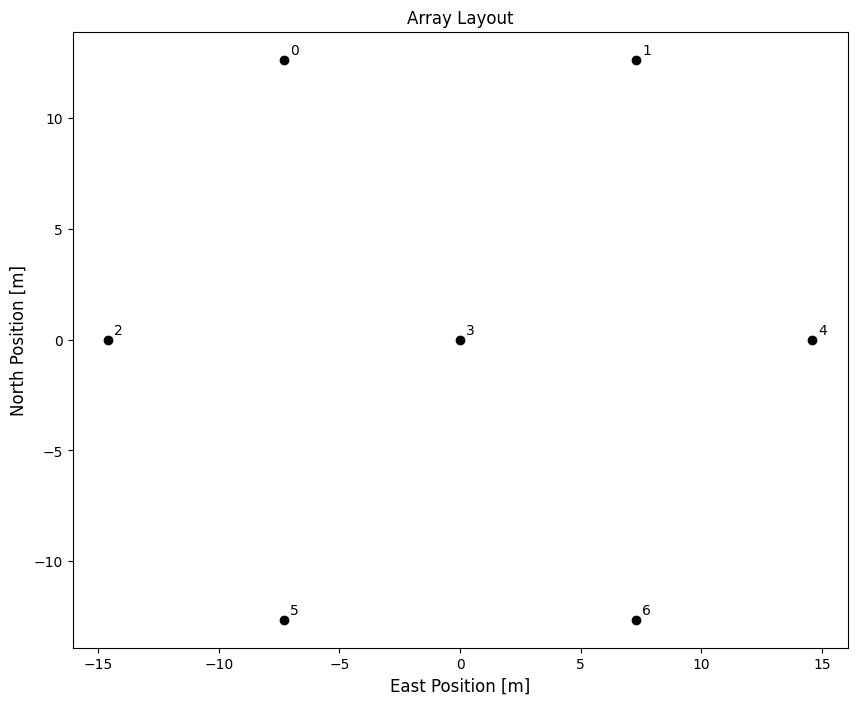

In [9]:
fig = sim.plot_array()

The ``data`` attribute can be used to access the ``UVData`` object used to store the simulated data and metadata:

In [10]:
type(sim.data)

pyuvdata.uvdata.uvdata.UVData

### Adding Effects

Effects may be added to a simulation by using the ``add`` method. This method takes one argument and variable keyword arguments: the required argument ``component`` may be either a string identifying the name of a ``hera_sim`` class (or an alias thereof, see below), or an appropriately defined callable class (see the section on using custom classes for exact details), while the variable keyword arguments parametrize the model. The ``add`` method simulates the effect and applies it to the entire array. Let's walk through an example.

We'll start by simulating diffuse foreground emission. For simplicity, we'll be using the H1C season default settings so that the number of extra parameters we need to specify is minimal.

In [11]:
# Use H1C season defaults.
hera_sim.defaults.set("h1c")

In [12]:
# Start off by simulating some foreground emission.
sim.add("diffuse_foreground")

You have not specified how to seed the random state. This effect might not be exactly recoverable.


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


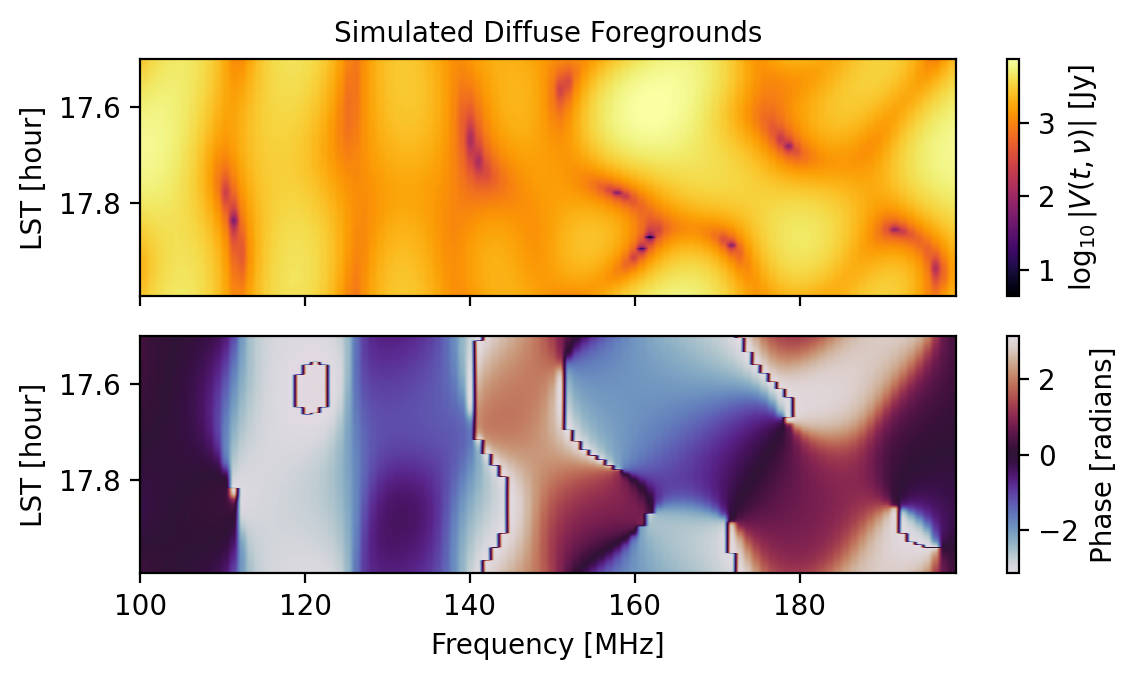

In [13]:
# Let's check out the data for the (0,1) baseline.
fig = waterfall(sim, title="Simulated Diffuse Foregrounds")
fig.tight_layout()

That was simple enough; however, basic use like this does not ensure that the simulation is as realistic as it can be with the tools provided by ``hera_sim``. For example, data that should be redundant is not redundant by default:

In [14]:
# (0,1) and (5,6) are redundant baselines, but...
np.all(sim.get_data(0, 1, "xx") == sim.get_data(5, 6, "xx"))

np.False_

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


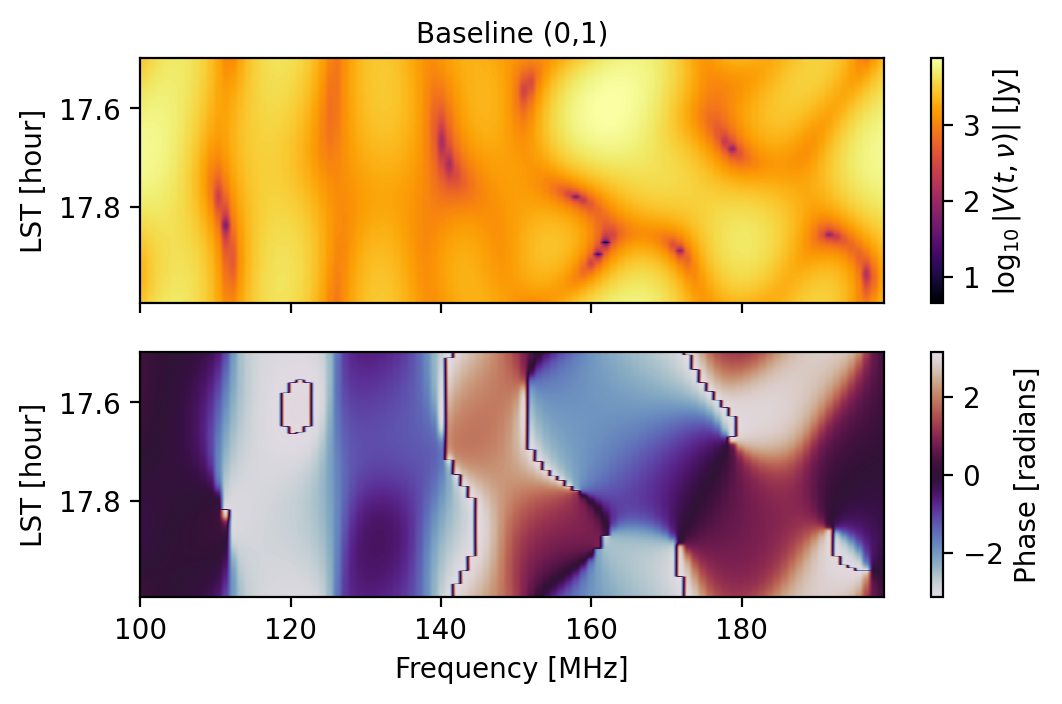

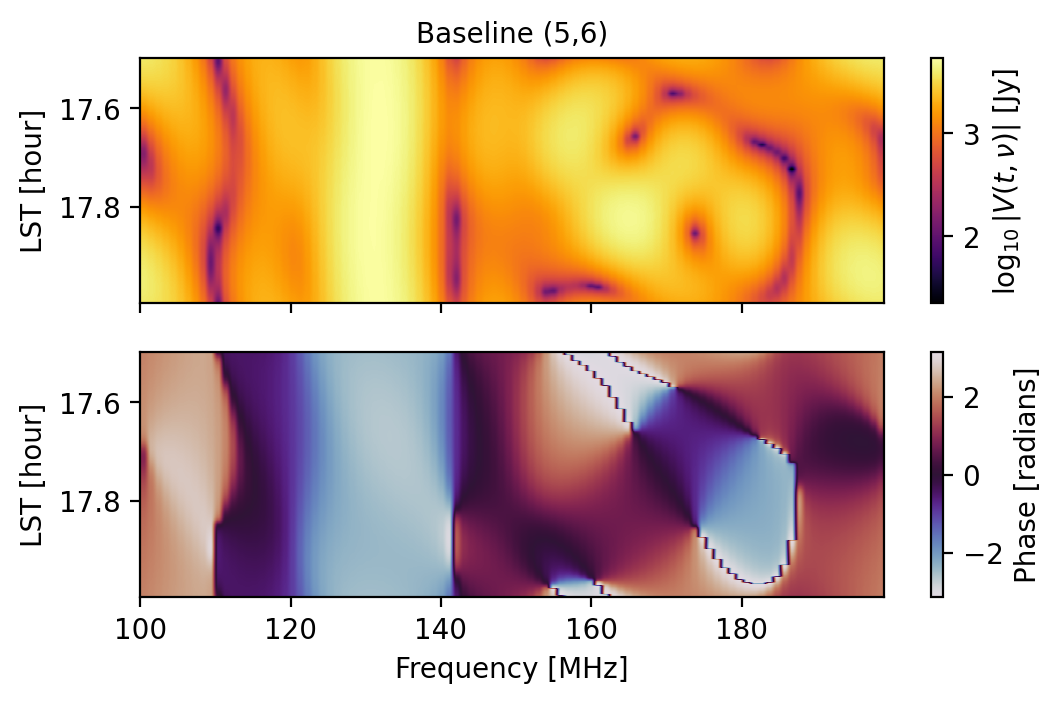

In [15]:
# As an extra comparison, let's plot them
fig1 = waterfall(sim, antpairpol=(0, 1, "xx"), title="Baseline (0,1)")
fig2 = waterfall(sim, antpairpol=(5, 6, "xx"), title="Baseline (5,6)")

We can ensure that a simulated effect that should be redundant is redundant by specifying that we use a "redundant" seed:

In [16]:
sim.refresh()  # Clear the contents and zero the data
sim.add(
    "diffuse_foreground",
    seed="redundant",  # Use the same random state for each redundant group
)

In [17]:
np.all(sim.get_data(0, 1, "xx") == sim.get_data(5, 6, "xx"))

np.True_

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


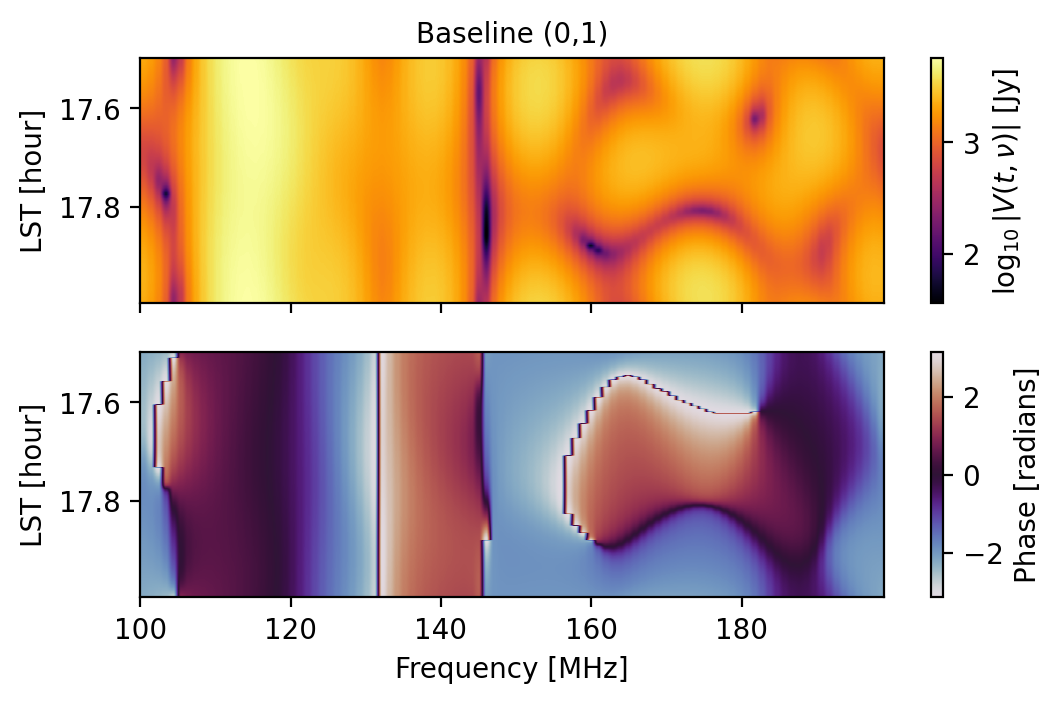

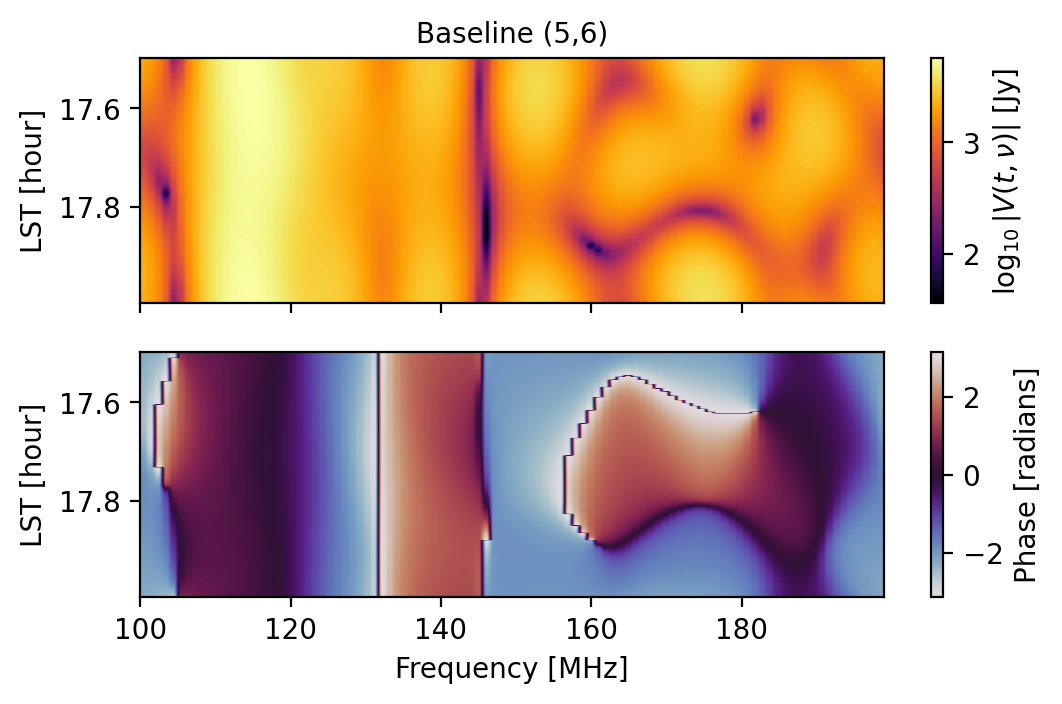

In [18]:
# Let's plot them again in case the direct comparison wasn't enough.
fig1 = waterfall(sim, antpairpol=(0, 1, "xx"), title="Baseline (0,1)")
fig2 = waterfall(sim, antpairpol=(5, 6, "xx"), title="Baseline (5,6)")

It is worth noting that the ``get_data`` method used here is the ``pyuvdata.UVData`` method that has been exposed to the ``Simulator``, not to be confused with the ``get`` method of the ``Simulator``, but more on that later.

In [19]:
# Go one step further with this example.
all_redundant = True
for red_grp in sim.red_grps:
    if len(red_grp) == 1:
        continue  # Nothing to see here
    base_vis = sim.get_data(red_grp[0])
    # Really check that data is redundant.
    for baseline in red_grp[1::]:
        all_redundant &= np.allclose(base_vis, sim.get_data(baseline))
all_redundant

True

### Retrieving Simulated Effects

The parameter values used for simulating an effect are stored so that the effect may be recovered at a later time by re-simulating the effect. For effects that have a random element (like bandpass gains or thermal noise), you'll want to make sure that the ``seed`` parameter is specified to ensure that the random state can be configured appropriately.

In [20]:
sim.refresh()
vis = sim.add(
    "noiselike_eor",
    eor_amp=1e-3,
    seed="redundant",
    ret_vis=True,  # Return a copy of the visibility for comparison later
)
sim.add(
    "gains",  # Apply a bandpass to the EoR data
    seed="once",  # Use the same seed each pass through the loop
)

As an extra note regarding the ``"once"`` setting used to set the random state in the above cell, this setting ensures that the same random state is used each iteration of the loop over the array. This isn't strictly necessary to use for multiplicative effects, since these are computed once before iterating over the array, but should be used for something like point-source foregrounds (which randomly populates the sky with sources each time the model is called).

In [21]:
# The data has been modified by the gains, so it won't match the original.
np.allclose(vis, sim.data.data_array)

False

In [22]:
# We can recover the simulated effect if we wanted to, though.
np.allclose(vis, sim.get("noiselike_eor"))

True

It is worth highlighting that the ``get`` method does *not* retrieve cached data (since simulated effects are not cached), but rather re-simulates the effect using the same parameter values and random states (since these are cached).

In [23]:
# Make explicitly clear that the simulated effects are not cached
vis is sim.get("noiselike_eor")

False

In [25]:
# Show that the same effect really is recovered.
gains = sim.get("gains")
new_vis = vis.copy()
for ant1, ant2, pol, blt_inds, pol_ind in sim._iterate_antpair_pols():
    # Modify the old visibilities by the complex gains manually.
    total_gain = gains[(ant1, pol[0])] * np.conj(gains[(ant2, pol[1])])
    new_vis[blt_inds, :, pol_ind] *= total_gain
np.allclose(new_vis, sim.data.data_array)  # Now check that they match.

True

Each time a component is added to the simulation, it is logged in the history:

In [26]:
print(sim.data.history)

hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added noiselikeeor using parameters:
eor_amp = 0.001
fringe_filter_type = tophat
hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added bandpass using parameters:
bp_poly = <hera_sim.interpolators.Bandpass object at 0x7f66183f9010>



### Saving A Simulation

Finally, we'll often want to write simulation data to disk. The simplest way to do this is with the ``write`` method:

In [28]:
tempdir = Path(tempfile.mkdtemp())
filename = tempdir / "simple_example.uvh5"
sim.write(filename, save_format="uvh5", check_autos=False)

key noiselike_eor_seed_(np.uint64(65536), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65537), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65538), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65539), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65540), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65541), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key 

In [29]:
filename in tempdir.iterdir()

True

In [30]:
# Check that the data is the same.
sim2 = Simulator(data=filename)
is_equiv = True
# Just do a basic check.
for attr in ("data_array", "freq_array", "time_array", "antenna_positions"):
    is_equiv &= np.all(getattr(sim.data, attr) == getattr(sim2.data, attr))
is_equiv

key gains_seed_('x',) in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key gains_seed_('xx',) in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65536), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65537), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65538), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65539), 'xx') in extra_keywords is longer than 8 characters. It will be truncated to 8 if written to uvfits or miriad file formats.
key noiselike_eor_seed_(np.uint64(65540), 'xx') in extr

np.False_

This concludes the section on basic use of the ``Simulator``.

## Advanced Use

The preceding examples should provide enough information to get you started with the ``Simulator``. The rest of this notebook shows some of the more advanced features offered by the ``Simulator``.

### Singling Out Baselines/Antennas/Polarizations

It is possible to simulate an effect for only a subset of antennas, baselines, and/or polarizations by making use of the ``vis_filter`` parameter when using the ``add`` method. Below are some examples.

In [31]:
sim.refresh()
vis_filter = [(0, 1), (3, 6)]  # Only do two baselines
sim.add("diffuse_foreground", vis_filter=vis_filter)
for baseline in sim.data.get_antpairs():
    if np.any(sim.get_data(baseline)):
        print(f"Baseline {baseline} has had an effect applied.")

Baseline (0, 1) has had an effect applied.
Baseline (3, 6) has had an effect applied.


You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [32]:
vis_filter = [1]  # Apply gains to only one antenna
vis_A = sim.get_data(0, 1)
vis_B = sim.get_data(3, 6)
sim.add("gains", vis_filter=vis_filter)
np.allclose(vis_A, sim.get_data(0, 1)), np.allclose(vis_B, sim.get_data(3, 6))

You have not specified how to seed the random state. This effect might not be exactly recoverable.


(False, True)

In [33]:
# Now something a little more complicated.
hera_sim.defaults.deactivate()  # Use the same initial params, but 2 pol
sim = Simulator(polarization_array=["xx", "yy"], **sim_params)
hera_sim.defaults.activate()

# Actually calculate the effects for the example.
vis_filter = [(0, 1, "yy"), (0, 2, "yy"), (1, 2, "yy")]
sim.add("noiselike_eor", vis_filter=vis_filter)
for antpairpol, vis in sim.data.antpairpol_iter():
    if np.any(vis):
        print(f"Antpairpol {antpairpol} has had an effect applied.")
# Apply gains only to antenna 0
vis_A = sim.get_data(0, 1, "yy")
vis_B = sim.get_data(0, 2, "yy")
vis_C = sim.get_data(1, 2, "yy")
sim.add("gains", vis_filter=[0])
(
    np.allclose(vis_A, sim.get_data(0, 1, "yy")),
    np.allclose(vis_B, sim.get_data(0, 2, "yy")),
    np.allclose(vis_C, sim.get_data(1, 2, "yy")),
)

Antpairpol (0, 1, 'yy') has had an effect applied.
Antpairpol (0, 2, 'yy') has had an effect applied.
Antpairpol (1, 2, 'yy') has had an effect applied.


The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.
You have not specified how to seed the random state. This effect might not be exactly recoverable.
You have not specified how to seed the random state. This effect might not be exactly recoverable.


(False, False, True)

For some insight into what's going on under the hood, this feature is implemented by recursively checking each entry in ``vis_filter`` and seeing if the current baseline + polarization (in the loop that simulates the effect for every baseline + polarization) matches any of the keys provided in ``vis_filter``. If any of the keys are a match, then the filter says to simulate the effect&mdash;this is important to note because it can lead to some unexpected consequences. For example:

In [34]:
seed = 12345  # Ensure that the random components are identical.
sim.refresh()
vis_filter = [(0, 1), "yy"]
vis_A = sim.add("diffuse_foreground", vis_filter=vis_filter, ret_vis=True, seed=seed)
sim.refresh()
vis_filter = [(0, 1, "yy")]
vis_B = sim.add("diffuse_foreground", vis_filter=vis_filter, ret_vis=True, seed=seed)
np.allclose(vis_A, vis_B)

False

In [35]:
# In case A, data was simulated for both polarizations for baseline (0,1)
blt_inds = sim.data.antpair2ind(0, 1, ordered=False)
np.all(vis_A[blt_inds])

np.True_

In [36]:
# As well as every baseline for polarization "yy"
np.all(vis_A[..., 1])

np.True_

In [37]:
# Only baseline (0,1) had an effect simulated for polarization "xx"
np.all(vis_A[..., 0])

np.False_

In [38]:
# Whereas for case B, only baseline (0, 1) with polarization "yy"
# had the simulated effect applied.
(
    np.all(vis_B[blt_inds, ..., 1]),  # Data for (0, 1, "yy")
    np.all(vis_B[blt_inds]),  # Data for both pols of (0, 1)
    np.all(vis_B[..., 1]),  # Data for all baselines with pol "yy"
)

(np.True_, np.False_, np.False_)

Here's an example of how the ``vis_filter`` parameter can be used to simulate a single antenna that is especially noisy.

In [39]:
hera_sim.defaults.deactivate()  # Pause the H1C defaults for a moment...
sim = Simulator(**sim_params)  # Only need one polarization for this example.
hera_sim.defaults.activate()  # Turn the defaults back on for simulating effects.
# Start by adding some foregrounds.
sim.add("diffuse_foreground", seed="redundant")
# Then add noise with a receiver temperature of 100 K to all baselines
# except those that contain antenna 0.
v = sim.get_data(0, 1)
vis_filter = [antpair for antpair in sim.get_antpairs() if 0 not in antpair]
sim.add("thermal_noise", Trx=100, seed="initial", vis_filter=vis_filter)
# Now make antenna 0 dramatically noisy.
sim.add(
    "thermal_noise", Trx=5e4, seed="initial", vis_filter=[0], component_name="noisy_ant"
)

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


In [40]:
# Recall that baselines (0,1) and (2,3) are redundant,
# so the only difference here is the noise.
jansky_to_kelvin = utils.jansky_to_kelvin(sim.freqs, hera_sim.defaults("omega_p"))
Tsky_A = sim.get_data(0, 1) * jansky_to_kelvin
Tsky_B = sim.get_data(2, 3) * jansky_to_kelvin
np.std(np.abs(Tsky_A)), np.std(np.abs(Tsky_B))

(np.float64(49.44724161886554), np.float64(44.035662346153224))

Notice that the final call to the ``add`` method specified a value for the parameter ``component_name``. This is especially useful when simulating an effect multiple times using the same class, as we have done here. As currently implemented, the ``Simulator`` would normally overwrite the parameters from the first application of noise with the parameters from the second application of noise; however, by specifying a name for the second application of noise, we can recover the two effects independently:

In [41]:
vis_A = sim.get("thermal_noise")
vis_B = sim.get("noisy_ant")
blt_inds = sim.data.antpair2ind(0, 1)
(
    np.any(vis_A[blt_inds]),  # The first application give (0, 1) noise,
    np.all(vis_B[blt_inds]),  # but the second application did.
)

(np.True_, np.True_)

With that, we conclude this section of the tutorial. This section should have provided you with sufficient examples to add effects to your own simulation in rather complicated ways&mdash;we recommend experimenting a bit on your own!

### Naming Components

This was briefly touched on in the previous section, but it is interesting enough to get its own section. By using the ``component_name`` parameter, it is possible to use the same model multiple times for simulating an effect and have the ``Simulator`` be able to recover every different effect simulated using that model. Here are some examples:

In [42]:
hera_sim.defaults.set("debug")
sim = Simulator(
    Ntimes=6 * 24,  # Do a full day
    integration_time=10 * 60,  # In 10 minute increments
    Nfreqs=100,  # Just to make the plots look nicer
)
sim.add(
    "pntsrc_foreground",
    nsrcs=5000,  # A lot of sources
    Smin=0.01,
    Smax=0.5,  # That are relatively faint
    component_name="faint sources",
    seed="once",
)
sim.add(
    "pntsrc_foreground",
    nsrcs=10,  # Just a few sources
    Smin=0.5,
    Smax=10,  # That are bright
    component_name="bright_sources",
    seed="once",
)

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


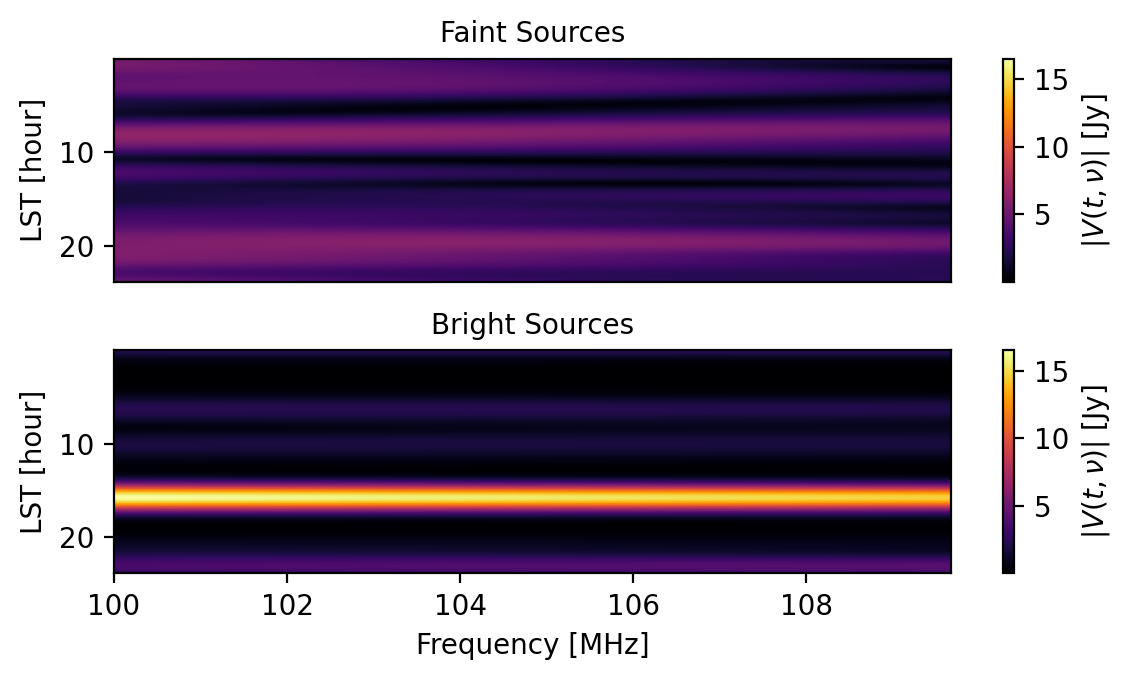

In [43]:
# Let's look at the data. First, we need to recover it.
faint_srcs = sim.get("faint sources", key=(0, 1, "xx"))
bright_srcs = sim.get("bright_sources", key=(0, 1, "xx"))

# Now let's get ready to plot.
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3.5), dpi=200)

# Use a common colorscale
vmin = min(np.abs(faint_srcs).min(), np.abs(bright_srcs).min())
vmax = max(np.abs(faint_srcs).max(), np.abs(bright_srcs).max())

# Actually make the plots
fig, ax1 = labeled_waterfall(
    faint_srcs,
    freqs=sim.freqs * units.GHz.to("Hz"),
    lsts=sim.lsts,
    set_title="Faint Sources",
    ax=ax1,
    mode="abs",
    vmin=vmin,
    vmax=vmax,
)
ax1.xaxis.set_visible(False)
fig, ax2 = labeled_waterfall(
    bright_srcs,
    freqs=sim.freqs * units.GHz.to("Hz"),
    lsts=sim.lsts,
    set_title="Bright Sources",
    mode="abs",
    ax=ax2,
    vmin=vmin,
    vmax=vmax,
)
fig.tight_layout()

So, by setting a value for the ``component_name`` parameter when calling the ``add`` method, it is possible to use a single model for simulating multiple different effects and later on recover the individual effects.

### Pre-Computing Fringe-Rate/Delay Filters

Some of the effects that are simulated utilize a fringe-rate filter and/or a delay filter in order to add to the realism of the simulation while keeping the computational overhead relatively low. Typically these filters are calculated on the fly; however, this can start to become an expensive part of the calculation for very large arrays. In order to address this, we implemented the ability to pre-compute these filters and use the cached filters instead. Here's an example.

In [44]:
# Make a big array with a high degree of redundancy.
big_array = hera_sim.antpos.hex_array(6, split_core=False, outriggers=0)
hera_sim.defaults.set("debug")  # Use short time and frequency axes.
sim = Simulator(array_layout=big_array)
delay_filter_kwargs = {"standoff": 30, "delay_filter_type": "gauss"}
fringe_filter_kwargs = {"fringe_filter_type": "gauss", "fr_width": 1e-4}
seed = 12345

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


In [45]:
# First, let's simulate an effect without pre-computing the filters.
vis_A = sim.add(
    "diffuse_foreground",
    delay_filter_kwargs=delay_filter_kwargs,
    fringe_filter_kwargs=fringe_filter_kwargs,
    seed=seed,
    ret_vis=True,
)

In [46]:
# Now do it using the pre-computed filters.
sim.calculate_filters(
    delay_filter_kwargs=delay_filter_kwargs, fringe_filter_kwargs=fringe_filter_kwargs
)
vis_B = sim.add("diffuse_foreground", seed=seed, ret_vis=True)

In [47]:
# Show that we get the same result.
np.allclose(vis_A, vis_B)

True

The above example shows how to use the filter caching mechanism and that it produces results that are identical to those when the filters are calculated on the fly, provided the filters are characterized the same way. Note, however, that this feature is still experimental and extensive benchmarking needs to be done to determine when it is beneficial to use the cached filters.

### Using Custom Models

In addition to using the models provided by ``hera_sim``, it is possible to make your own models and add an effect to the simulation using the custom model and the ``Simulator``. If you would like to do this, then you need to follow some simple rules for writing the custom model:  

* A component base class must be defined using the ``@component`` decorator.
* Models must inherit from the component base class.
* The model call signature must have ``freqs`` as a parameter. Additive components (like visibilities) must also take ``lsts`` as a parameter.
    * Additive components must return a ``np.ndarray`` with shape ``(lsts.size, freqs.size)``.
    * Multiplicative components must have a class attribute ``is_multiplicative`` that is set to ``True``, and they must return a dictionary mapping antenna numbers to ``np.ndarray``s with shape ``(freqs.size,)`` or ``(lsts.size, freqs.size)``.
* Frequencies will always be passed in units of GHz, and LSTs will always be passed in units of radians.  

An example of how to do this is provided in the following section.

#### Registering Classes

In [48]:
# Minimal example for using custom classes.
# First, make the base class that the custom model inherits from.
from hera_sim import component


@component
class Example:
    # The base class doesn't *need* a docstring, but writing one is recommended
    pass


class TestAdd(Example):
    def __init__(self):
        pass

    def __call__(self, lsts, freqs):
        return np.ones((len(lsts), len(freqs)), dtype=complex)


sim.refresh()
sim.add(TestAdd)  # You can add the effect by directly referencing the class
np.all(sim.data.data_array == 1)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


np.True_

In [50]:
# Now for a multiplicative effect
class TestMult(Example):
    is_multiplicative = True

    def __init__(self):
        pass

    def __call__(self, freqs, ants):
        print(freqs)
        print(ants)
        return {ant: i * np.ones_like(freqs) for i, ant in enumerate(ants)}


mult_model = TestMult()
sim.add(mult_model)  # You can also use an instance of the class
np.all(sim.get_data(1, 2) == 2)

[0.1        0.10009766 0.10019531 0.10029297 0.10039062 0.10048828
 0.10058594 0.10068359 0.10078125 0.10087891]
<class 'inspect._empty'>


You have not specified how to seed the random state. This effect might not be exactly recoverable.


TypeError: 'type' object is not iterable

In [ ]:
# You can also give the class an alias it may be referenced by
class TestAlias(Example):
    is_multiplicative = False
    _alias = ("bias",)

    def __init__(self):
        pass

    def __call__(self, lsts, freqs, bias=10):
        return bias * np.ones((lsts.size, freqs.size), dtype=complex)


sim.refresh()
sim.add("bias")  # Or you can just use the name (or an alias) of the model
np.all(sim.data.data_array == 10)

True

How does this work? Basically all that happens is that the ``@component`` decorator ensures that every model that is subclassed from the new simulation component is tracked in the component's ``_models`` attribute.

In [ ]:
Example._models

{'testadd': __main__.TestAdd,
 'testmult': __main__.TestMult,
 'testalias': __main__.TestAlias,
 'bias': __main__.TestAlias}

It is also worth noting that you can make new models from components that already exist in ``hera_sim``! We could, for example, make a new RFI model like so:

In [ ]:
class NewRFI(hera_sim.rfi.RFI):
    _alias = ("example_rfi",)
    """Doesn't do anything, just an example."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, lsts, freqs):
        """This class will be added to the list of known components, though!"""
        return np.zeros((lsts.size, freqs.size), dtype=complex)

In case it isn't clear: defining a new simulation component and making a model of that component makes ``hera_sim`` automatically aware of its existence, and so the ``Simulator`` is able to find it with ease (provided there isn't a name conflict). See the last entry of the following text.

In [ ]:
print(hera_sim.components.list_all_components())

array:
  lineararray
  hexarray
eor:
  noiselikeeor | noiselike_eor
foreground:
  diffuseforeground | diffuse_foreground
  pointsourceforeground | pntsrc_foreground
noise:
  thermalnoise | thermal_noise
rfi:
  stations | rfi_stations
  impulse | rfi_impulse
  scatter | rfi_scatter
  dtv | rfi_dtv
  newrfi | example_rfi
gain:
  bandpass | gains | bandpass_gain
  reflections | reflection_gains | sigchain_reflections
  reflectionspectrum | reflection_spectrum
crosstalk:
  crosscouplingcrosstalk | cross_coupling_xtalk
  crosscouplingspectrum | cross_coupling_spectrum | xtalk_spectrum
  overaircrosscoupling
  whitenoisecrosstalk | whitenoise_xtalk | white_noise_xtalk
example:
  testadd
  testmult
  testalias | bias



### Saving Data in Chunks

We finally get to the last of the advanced features of the ``Simulator``: writing data to disk in a way that resembles how the correlator writes HERA data to disk. HERA data files typically only contain a few integrations, and follow a standard naming convention. With the ``chunk_sim_and_save`` method, you can write files to disk so that they are chunked into a set number of integrations per file and follow a particular naming scheme. Here's an example:

In [ ]:
# We'll use a new temporary directory
tempdir = Path(tempfile.mkdtemp())
sim.chunk_sim_and_save(
    save_dir=tempdir,  # Write the files to tempdir
    Nint_per_file=2,  # Include 2 integrations per file
    prefix="example",  # Prefix the file basename with "example"
    sky_cmp="custom",  # Tack on "custom" after the JD in the filename
    state="true",  # Tack on "true" after "custom" in the filename
    filetype="uvh5",  # Use the uvh5 file format
)

In [ ]:
print("\n".join(str(f) for f in tempdir.iterdir()))

/tmp/tmp3m3cjqb0/example.2458119.50000.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50149.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50198.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50050.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50074.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50025.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50099.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50173.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50124.custom.true.uvh5
/tmp/tmp3m3cjqb0/example.2458119.50223.custom.true.uvh5


The filename format is ``save_dir/[{prefix}.]{jd_major}.{jd_minor}[.{sky_cmp}][.{state}].{filetype}``. Note that this hasn't been tested with other filetypes (e.g. ``miriad``), so results may vary if you deviate from the ``uvh5`` format.

It's also possible to provide reference files for deciding how to chunk the files:

In [ ]:
sim.chunk_sim_and_save(
    save_dir=tempdir,
    ref_files=list(tempdir.iterdir()),
    prefix="new",
    sky_cmp="example",
    state="files",
    filetype="uvh5",
)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


In [ ]:
print("\n".join(str(f) for f in tempdir.iterdir() if str(f).endswith("files.uvh5")))

/tmp/tmp3m3cjqb0/new.2458119.50173.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50025.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50074.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50000.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50124.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50223.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50149.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50198.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50099.example.files.uvh5
/tmp/tmp3m3cjqb0/new.2458119.50050.example.files.uvh5


## The ``run_sim`` Method

The ``Simulator`` class also features the ``run_sim`` method, which allows you to run an entire simulation with a single method call. The idea behind this is that one might want to decide all of the simulation parameters beforehand, or have a configuration file specifying the simulation parameters, and then run the entire simulation in one go. Below are some examples of how to use the ``run_sim`` method.

### Defining A Configuration Dictionary

We can specify a sequence of steps to be simulated by using a dictionary that maps models to dictionaries that specify their parameter values. This simulation will include diffuse foregrounds, a noiselike EoR signal, and bandpass gains.

In [51]:
hera_sim.defaults.deactivate()
sim = Simulator(**sim_params)
config = {
    "diffuse_foreground": {
        "Tsky_mdl": hera_sim.defaults("Tsky_mdl"),
        "omega_p": np.ones_like(sim.freqs),
    },
    "noiselike_eor": {"eor_amp": 1e-4},
    "gains": {"dly_rng": (-50, 50)},
}
sim.run_sim(**config)

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.
You have not specified how to seed the random state. This effect might not be exactly recoverable.


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


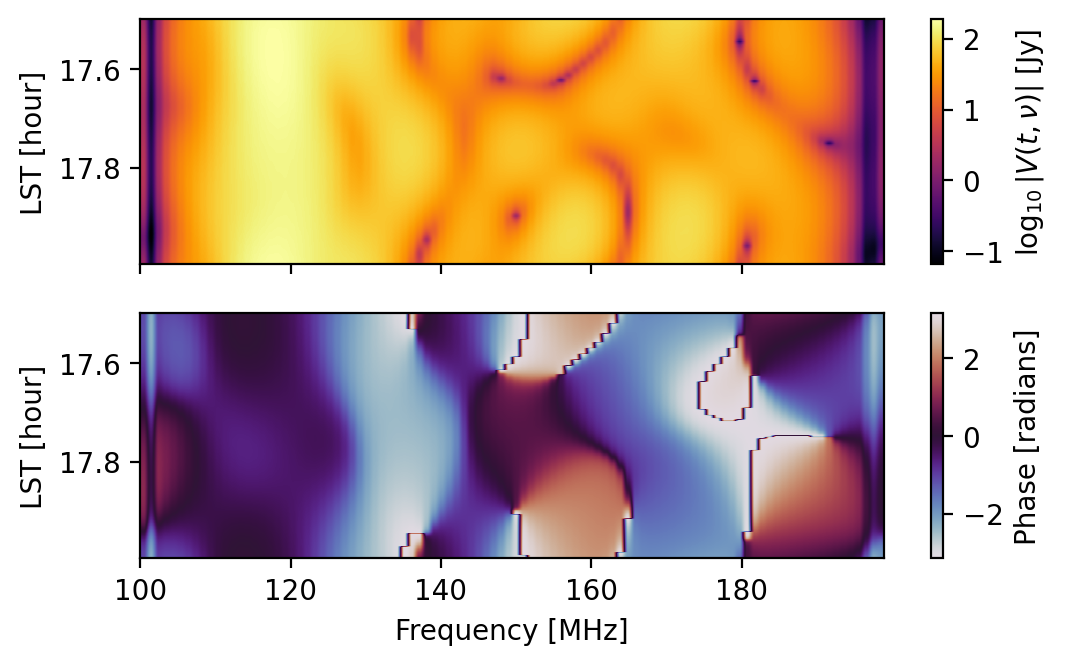

In [52]:
# Let's take a look at some of the data
fig = waterfall(sim)

In [53]:
# Now let's verify that the simulation contains what we want.
print(sim.data.history)

Object created by new_uvdata() at 2024-08-27 10:07:04.964 using pyuvdata version 3.0.0.hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added diffuseforeground using parameters:
Tsky_mdl = <hera_sim.interpolators.Tsky object at 0x7f661bf23f80>
omega_p = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added noiselikeeor using parameters:
eor_amp = 0.0001
hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added bandpass using parameters:
dly_rng = (-50, 50)



### Using A Configuration File

Instead of using a dictionary to specify the parameters, we can instead use a configuration YAML file:

In [54]:
cfg_file = tempdir / "config.yaml"
cfg_file.touch()
with open(cfg_file, "w") as cfg:
    cfg.write(
        """
        pntsrc_foreground:
            nsrcs: 10000
            Smin: 0.2
            Smax: 20
            seed: once
        noiselike_eor:
            eor_amp: 0.005
            seed: redundant
        reflections:
            amp: 0.01
            dly: 200
            seed: once
        """
    )
sim.refresh()
sim.run_sim(sim_file=cfg_file)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


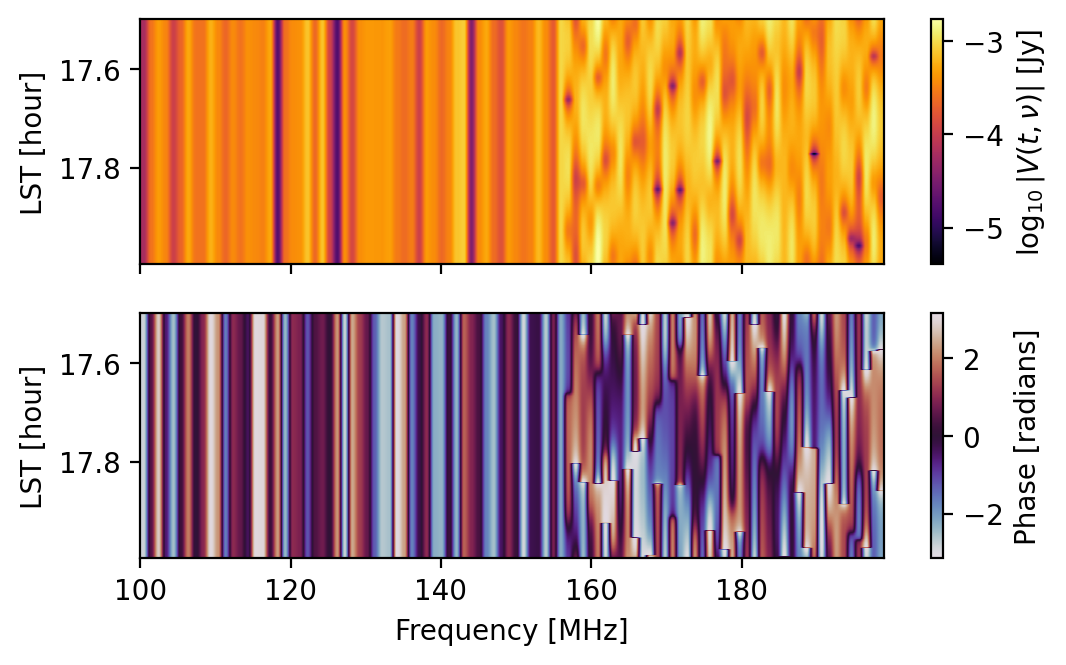

In [55]:
# Again, let's check out some data.
fig = waterfall(sim)

In [56]:
# Then verify the history.
print(sim.data.history)

hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added pointsourceforeground using parameters:
nsrcs = 10000
Smin = 0.2
Smax = 20
hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added noiselikeeor using parameters:
eor_amp = 0.005
hera_sim v4.2.3.dev63+g0e040d1.d20240822: Added reflections using parameters:
amp = 0.01
dly = 200

